In [368]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium


from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from folium.plugins import HeatMap
from mpl_toolkits.mplot3d import Axes3D


# Setting to make numbers easier to read on display
pd.options.display.float_format = '{:20.2f}'.format

# **Data Collection**

---



In [369]:
sales_df = pd.read_csv('/content/sales.csv')
customers_df = pd.read_csv('/content/customer.csv')
stores_df = pd.read_csv('/content/stores.csv')

In [370]:
#Scrape or integrate external dataset - Weather
weather_data = []

# API Key
api_key = "c01b61db71fd733defb8ec1ed2a79f82"

# Fetch store locations from stores csv
store_locations = stores_df['Location'].unique()

# Convert date column to datetime and extract unique dates
sales_df['invoice_date'] = pd.to_datetime(sales_df['invoice_date'], format='%Y-%m-%d')
unique_dates = sales_df['invoice_date'].dt.strftime('%Y-%m-%d').unique()

# Fetch weather data for each city (store location)
for city in store_locations:
    for date in unique_dates:
        # API URL for the current weather
        url = f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=imperial'

        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                # Extract key weather metrics
                weather_data.append({
                    "City": city,
                    "Date": date,
                    "Temperature": data['main']['temp'],
                    "Weather_Description": data['weather'][0]['description']
                })
            else:
                print(f"Failed to fetch weather data for {city} on {date}: {response.status_code}")
        except Exception as e:
            print(f"Error fetching data for {city} on {date}: {e}")

#Convert weather data to DataFrame
weather_df = pd.DataFrame(weather_data)

#Save the weather data to a CSV file
weather_data_path = "/content/weather.csv"
weather_df.to_csv(weather_data_path, index=False)



In [371]:
#Scrape or integrate external dataset - Holiday
# API Key
holiday_api_key= "Hef8e2pavaXX1GcBCHLzxhsF3TN2bQJU"

# Country code and years
country_code = "US"
sales_df['invoice_date'] = pd.to_datetime(sales_df['invoice_date'], format='%d-%m-%Y')
years = sales_df['invoice_date'].dt.year.unique()

# List to store holiday data
holiday_data = []

# Fetch holiday data for each year
for year in years:
    url = f"https://calendarific.com/api/v2/holidays?api_key={holiday_api_key}&country={country_code}&year={year}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            holidays = response.json().get("response", {}).get("holidays", [])
            for holiday in holidays:
                holiday_data.append({
                    "Date": holiday["date"]["iso"],
                    "Name": holiday["name"],
                    "Type": holiday["type"]
                })
        else:
            print(f"Failed to fetch holiday data for {year}: {response.status_code}")
    except Exception as e:
        print(f"Error fetching data for {year}: {e}")

# Convert to DataFrame
holiday_df = pd.DataFrame(holiday_data)

# Save the data
holiday_data_path = "/content/holidays.csv"
holiday_df.to_csv(holiday_data_path, index=False)

# **Data Exploration**

---



***Customer dataset***

In [372]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     99457 non-null  object 
 1   gender          99457 non-null  object 
 2   age             99338 non-null  float64
 3   payment_method  99457 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.0+ MB


In [373]:
customers_df.describe()

,age
count,99338.00
mean,43.43
std,14.99
min,18.00
25%,30.00
50%,43.00
75%,56.00
max,69.00


In [374]:
customers_df.describe(include='O')

,customer_id,gender,payment_method
count,99457,99457,99457
unique,99457,2,3
top,C241288,Female,Cash
freq,1,59482,44447


In [375]:
#pattern check
customers_df['customer_id'].str.match(r'C\d+').sum()

99457

In [376]:
customers_df['customer_id'].str.len().value_counts()

,count
customer_id,
7,99457


In [377]:
customers_df["gender"].unique()


array(['Female', 'Male'], dtype=object)

In [378]:
customers_df["payment_method"].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

***Sales dataset***

In [379]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14601 entries, 0 to 14600
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invoice_no     14601 non-null  object 
 1   customer_id    14601 non-null  object 
 2   category       14601 non-null  object 
 3   quantity       14601 non-null  int64  
 4   price          14601 non-null  float64
 5   invoice_date   14601 non-null  object 
 6   shopping_mall  14601 non-null  object 
 7   Store_ID       14601 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 912.7+ KB


In [380]:
sales_df.head(10)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019


In [381]:
sales_df.describe(include='O')

,invoice_no,customer_id,category,invoice_date,shopping_mall,Store_ID
count,14601,14601,14601,14601,14601,14601
unique,14601,1000,5,797,10,50
top,I000001,C000726,Clothing,2023-02-01,Forum Istanbul,S0019
freq,1,28,2988,34,1521,334


In [382]:
#pattern check
sales_df['invoice_no'].str.match(r'I\d+').sum()

14601

In [383]:
sales_df['customer_id'].str.match(r'C\d+').sum()

14601

In [384]:
sales_df['invoice_no'].str.len().value_counts()

,count
invoice_no,
7,14601


In [385]:
sales_df["category"].unique()

array(['Shoes', 'Books', 'Clothing', 'Electronics', 'Home'], dtype=object)

In [386]:
sales_df["shopping_mall"].unique()

array(['Mall of Istanbul', 'Viaport Outlet', 'Forum Istanbul',
       'Istinye Park', 'Kanyon', 'Zorlu Center', 'Cevahir AVM',
       'Metropol AVM', 'Metrocity', 'Emaar Square Mall'], dtype=object)

***Stores dataset***

In [387]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store_ID       50 non-null     object
 1   shopping_mall  50 non-null     object
 2   Location       50 non-null     object
 3   Size           50 non-null     object
 4   Category       50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


In [388]:
stores_df.describe(include='O')

,Store_ID,shopping_mall,Location,Size,Category
count,50,50,50,50,50
unique,50,10,5,3,5
top,S0020,Mall of Istanbul,Chicago,Medium,Books
freq,1,8,15,20,13


In [389]:
#pattern check
stores_df['Store_ID'].str.match(r'S\d+').sum()

50

In [390]:
stores_df['shopping_mall'].unique()

array(['Istinye Park', 'Metrocity', 'Mall of Istanbul', 'Viaport Outlet',
       'Metropol AVM', 'Zorlu Center', 'Kanyon', 'Forum Istanbul',
       'Cevahir AVM', 'Emaar Square Mall'], dtype=object)

In [391]:
stores_df['Size'].unique()

array(['Small', 'Large', 'Medium'], dtype=object)

In [392]:
stores_df['Location'].unique()

array(['Dallas', 'Chicago', 'San Francisco', 'New York', 'Houston'],
      dtype=object)

***Weather dataset***

In [393]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 3985 non-null   object 
 1   Date                 3985 non-null   object 
 2   Temperature          3985 non-null   float64
 3   Weather_Description  3985 non-null   object 
dtypes: float64(1), object(3)
memory usage: 124.7+ KB


In [394]:
weather_df.describe(include='O')

,City,Date,Weather_Description
count,3985,3985,3985
unique,5,797,8
top,Chicago,2022-08-05,clear sky
freq,797,5,1525


In [395]:
weather_df.head(10)

,City,Date,Temperature,Weather_Description
0,Chicago,2022-08-05,11.32,rain
1,Chicago,2021-12-12,11.32,snow
2,Chicago,2021-11-09,11.32,clear sky
3,Chicago,2021-05-16,11.32,thunderstorm
4,Chicago,2021-10-24,11.32,overcast clouds
5,Chicago,2022-05-24,11.32,broken clouds
6,Chicago,2022-03-13,11.32,broken clouds
7,Chicago,2021-01-13,11.32,broken clouds
8,Chicago,2021-11-04,11.32,thunderstorm
9,Chicago,2021-08-22,11.32,broken clouds


In [396]:
weather_df.describe(include='O')

,City,Date,Weather_Description
count,3985,3985,3985
unique,5,797,8
top,Chicago,2022-08-05,clear sky
freq,797,5,1525


In [397]:
weather_df['Weather_Description'].unique()

array(['rain', 'snow', 'clear sky', 'thunderstorm', 'overcast clouds',
       'broken clouds', 'drizzle', 'fog'], dtype=object)

In [398]:
weather_df['City'].unique()

array(['Chicago', 'Dallas', 'Houston', 'New York', 'Los Angeles'],
      dtype=object)

***Holidays dataset***

In [399]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907 entries, 0 to 1906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1907 non-null   object
 1   Name    1907 non-null   object
 2   Type    1907 non-null   object
dtypes: object(3)
memory usage: 44.8+ KB


In [400]:
holidays_df.describe(include='O')

,Date,Name,Type
count,1907,1907,1907
unique,797,518,17
top,2023-06-19,Juneteenth,['United Nations observance']
freq,37,46,530


In [401]:
holidays_df['Date'].unique()


array(['2022-01-01', '2022-01-03', '2022-01-04', '2022-01-06',
       '2022-01-07', '2022-01-08', '2022-01-13', '2022-01-14',
       '2022-01-16', '2022-01-17', '2022-01-19', '2022-01-24',
       '2022-01-26', '2022-01-27', '2022-01-29', '2022-01-30',
       '2022-02-01', '2022-02-02', '2022-02-04', '2022-02-06',
       '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
       '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-20',
       '2022-02-21', '2022-02-25', '2022-02-28', '2022-03-01',
       '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07',
       '2022-03-08', '2022-03-10', '2022-03-13T02:00:00-05:00',
       '2022-03-17', '2022-03-18', '2022-03-20',
       '2022-03-20T11:33:25-04:00', '2022-03-21', '2022-03-22',
       '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26',
       '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
       '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
       '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-10',
    

In [402]:
holidays_df.describe(include='O')

,Date,Name,Type
count,1907,1907,1907
unique,797,518,17
top,2023-06-19,Juneteenth,['United Nations observance']
freq,37,46,530


In [403]:
holidays_df.head(10)

,Date,Name,Type
0,2022-01-01,New Year's Day,['Local holiday']
1,2022-01-01,New Year's Day,['Local holiday']
2,2022-01-01,New Year's Day,['Local holiday']
3,2022-01-01,New Year's Day,['Local holiday']
4,2022-01-01,New Year's Day,['Local holiday']
5,2022-01-01,New Year's Day,['National holiday']
6,2022-01-03,New Year's Day (substitute),['Local holiday']
7,2022-01-03,New Year's Day (substitute),['Local holiday']
8,2022-01-04,World Braille Day,['United Nations observance']
9,2022-01-06,Epiphany,['Christian']


In [404]:
pre_preprocessing_summary = {
    "Customers - Missing Values": customers_df.isnull().sum(),
    "Sales - Missing Values": sales_df.isnull().sum(),
    "Stores - Missing Values": stores_df.isnull().sum(),
    "Weather - Missing Values": weather_df.isnull().sum(),
    "Holidays - Missing Values": holidays_df.isnull().sum(),
}

pre_preprocessing_summary

{'Customers - Missing Values': customer_id         0
 gender              0
 age               119
 payment_method      0
 dtype: int64,
 'Sales - Missing Values': invoice_no       0
 customer_id      0
 category         0
 quantity         0
 price            0
 invoice_date     0
 shopping_mall    0
 Store_ID         0
 dtype: int64,
 'Stores - Missing Values': Store_ID         0
 shopping_mall    0
 Location         0
 Size             0
 Category         0
 dtype: int64,
 'Weather - Missing Values': City                   0
 Date                   0
 Temperature            0
 Weather_Description    0
 dtype: int64,
 'Holidays - Missing Values': Date    0
 Name    0
 Type    0
 dtype: int64}

Notes

Customer - 'Age' has missing values

Sales - 'Invoice date' data type change to date

Stores - looks good

Weather - 'Date' datatype change to date

Holidays -  

* 'Date' change datatype to date
* 'Date' has additional timestamps
* remove brackets and quotes from 'Type'



# **Data Cleaning**

---

In [405]:
# Creating copies of each dataset before preprocessing
original_customers_df = customers_df.copy()
original_holidays_df = holidays_df.copy()
original_sales_df = sales_df.copy()
original_stores_df = stores_df.copy()
original_weather_df = weather_df.copy()


In [406]:
#customers data
# Drop missing values of 'age'
customers_df = customers_df.dropna(subset=['age'])

In [407]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99338 entries, 0 to 99456
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     99338 non-null  object 
 1   gender          99338 non-null  object 
 2   age             99338 non-null  float64
 3   payment_method  99338 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.8+ MB


In [408]:
#sales data

#convert dates to datetime format in sales
sales_df['invoice_date'] = pd.to_datetime(sales_df['invoice_date'], format='%Y-%m-%d')

In [409]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14601 entries, 0 to 14600
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   invoice_no     14601 non-null  object        
 1   customer_id    14601 non-null  object        
 2   category       14601 non-null  object        
 3   quantity       14601 non-null  int64         
 4   price          14601 non-null  float64       
 5   invoice_date   14601 non-null  datetime64[ns]
 6   shopping_mall  14601 non-null  object        
 7   Store_ID       14601 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 912.7+ KB


In [410]:
#weather data

#convert datatype to datetime
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%Y-%m-%d')

In [411]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 3985 non-null   object        
 1   Date                 3985 non-null   datetime64[ns]
 2   Temperature          3985 non-null   float64       
 3   Weather_Description  3985 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 124.7+ KB


In [412]:
#Holiday data

# Clean 'Type' column in holidays dataset
holidays_df['Type'] = holidays_df['Type'].str.strip("[]").str.replace("'", "")

In [413]:
#Convert 'Date' columns to datetime in holiday coercing invalid entries to NaT
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], errors='coerce')

In [414]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907 entries, 0 to 1906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1889 non-null   datetime64[ns]
 1   Name    1907 non-null   object        
 2   Type    1907 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 44.8+ KB


In [415]:
#Check missing dates
missing_dates = holidays_df[holidays_df['Date'].isna()]
print(missing_dates)

     Date                         Name                               Type
94    NaT  Daylight Saving Time starts  Clock change/Daylight Saving Time
101   NaT                March Equinox                             Season
364   NaT                June Solstice                             Season
465   NaT            September Equinox                             Season
550   NaT    Daylight Saving Time ends  Clock change/Daylight Saving Time
631   NaT            December Solstice                             Season
748   NaT  Daylight Saving Time starts  Clock change/Daylight Saving Time
753   NaT                March Equinox                             Season
981   NaT                June Solstice                             Season
1085  NaT            September Equinox                             Season
1176  NaT    Daylight Saving Time ends  Clock change/Daylight Saving Time
1252  NaT            December Solstice                             Season
1374  NaT  Daylight Saving Time starts

In [416]:
#Drop missing dates
holidays_df = holidays_df.dropna(subset=['Date'])

In [417]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1889 entries, 0 to 1906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1889 non-null   datetime64[ns]
 1   Name    1889 non-null   object        
 2   Type    1889 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 59.0+ KB


In [418]:
holidays_df.head(10)

,Date,Name,Type
0,2022-01-01,New Year's Day,Local holiday
1,2022-01-01,New Year's Day,Local holiday
2,2022-01-01,New Year's Day,Local holiday
3,2022-01-01,New Year's Day,Local holiday
4,2022-01-01,New Year's Day,Local holiday
5,2022-01-01,New Year's Day,National holiday
6,2022-01-03,New Year's Day (substitute),Local holiday
7,2022-01-03,New Year's Day (substitute),Local holiday
8,2022-01-04,World Braille Day,United Nations observance
9,2022-01-06,Epiphany,Christian


In [419]:
# Check for duplicates in each dataset

duplicates_summary = {
    "Customers": customers_df.duplicated().sum(),
    "Sales": sales_df.duplicated().sum(),
    "Stores": stores_df.duplicated().sum(),
    "Weather": weather_df.duplicated().sum(),
    "Holidays": holidays_df.duplicated().sum()
}

duplicates_summary

{'Customers': 0, 'Sales': 0, 'Stores': 0, 'Weather': 0, 'Holidays': 195}

In [420]:
# drop duplicates for holidays dataset
holidays_df.drop_duplicates(inplace=True)

In [421]:
# Display summaries after preprocessing
preprocessing_summary = {
    "Customers - Missing Values": customers_df.isnull().sum(),
    "Holidays - Missing Values": holidays_df.isnull().sum(),
    "Sales - Missing Values": sales_df.isnull().sum(),
    "Stores - Missing Values": stores_df.isnull().sum(),
    "Weather - Missing Values": weather_df.isnull().sum(),
}

preprocessing_summary

{'Customers - Missing Values': customer_id       0
 gender            0
 age               0
 payment_method    0
 dtype: int64,
 'Holidays - Missing Values': Date    0
 Name    0
 Type    0
 dtype: int64,
 'Sales - Missing Values': invoice_no       0
 customer_id      0
 category         0
 quantity         0
 price            0
 invoice_date     0
 shopping_mall    0
 Store_ID         0
 dtype: int64,
 'Stores - Missing Values': Store_ID         0
 shopping_mall    0
 Location         0
 Size             0
 Category         0
 dtype: int64,
 'Weather - Missing Values': City                   0
 Date                   0
 Temperature            0
 Weather_Description    0
 dtype: int64}

In [422]:
#data lost
print(len(sales_df)/len(original_sales_df))
print(len(customers_df)/len(original_customers_df))
print(len(stores_df)/len(original_stores_df))
print(len(weather_df)/len(original_weather_df))
print(len(holidays_df)/len(original_holidays_df))

1.0
0.9988035030214062
1.0
1.0
0.8883062401678028


Dropped around 11% data from holidays and almost negligible from customers during cleaning

# **FEATURE ENGINEERING**

---



***SALES***

In [423]:
sales_df.head(10)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019


In [424]:
sales_df['total_sales']= sales_df['price']*sales_df['quantity']
sales_df.head(10)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007,1575.15
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033,4268.08
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026,5594.40
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026,4170.39
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019,8488.44


In [425]:
aggregated_df= sales_df.groupby('customer_id', as_index=False).agg(Monetary_value = ("total_sales","sum"),
  Frequency = ("invoice_no","nunique"),
  lastinvoicedate = ("invoice_date","max"))

aggregated_df.head(5)

,customer_id,Monetary_value,Frequency,lastinvoicedate
0,C000001,43290.57,15,2023-02-05
1,C000002,27607.01,14,2022-12-04
2,C000003,35368.57,15,2022-12-22
3,C000004,35018.94,13,2023-02-20
4,C000005,28847.11,16,2023-02-11


In [426]:
max_invoice_date = aggregated_df['lastinvoicedate'].max()

aggregated_df['Recency'] = (max_invoice_date - aggregated_df['lastinvoicedate']).dt.days
aggregated_df.head(5)

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency
0,C000001,43290.57,15,2023-02-05,31
1,C000002,27607.01,14,2022-12-04,94
2,C000003,35368.57,15,2022-12-22,76
3,C000004,35018.94,13,2023-02-20,16
4,C000005,28847.11,16,2023-02-11,25


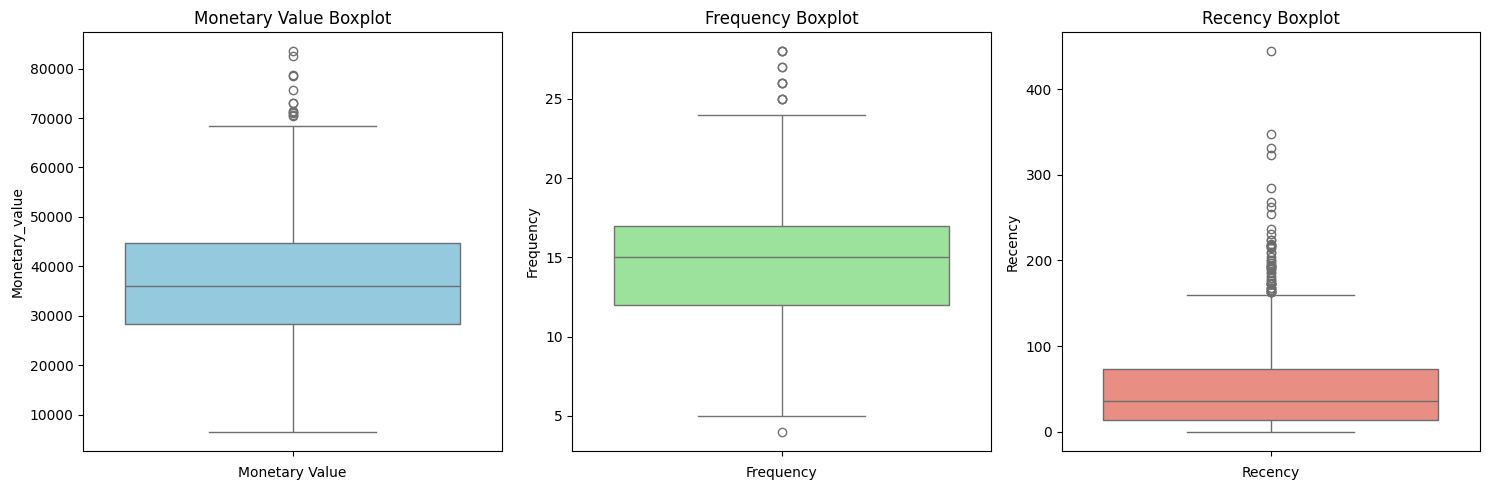

In [427]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['Monetary_value'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


In [428]:
#finding monetary outliers

M_Q1 = aggregated_df["Monetary_value"].quantile(0.25)
M_Q3 = aggregated_df["Monetary_value"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["Monetary_value"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["Monetary_value"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()

,Monetary_value,Frequency,lastinvoicedate,Recency
count,12.00,12.00,12,12.00
mean,74943.72,22.83,2023-02-04 16:00:00,31.33
min,70457.51,20.00,2022-10-13 00:00:00,0.00
25%,71080.71,20.00,2023-02-06 12:00:00,7.00
50%,73065.95,22.00,2023-02-18 12:00:00,17.50
75%,78526.01,26.00,2023-03-01 00:00:00,29.50
max,83470.57,27.00,2023-03-08 00:00:00,146.00
std,4719.18,2.79,NaN,42.19


In [429]:
monetary_outliers_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency
113,C000114,70948.27,20,2023-02-10,26
136,C000137,73095.83,24,2023-02-21,15
160,C000161,83470.57,21,2023-03-01,7
293,C000294,75591.04,20,2022-10-13,146
363,C000364,73036.07,26,2023-03-05,3
380,C000381,78668.61,22,2023-02-28,8
406,C000407,70529.70,20,2023-03-01,7
669,C000670,82444.77,27,2023-02-12,24
675,C000676,78478.48,22,2023-02-16,20
771,C000772,71478.95,26,2023-01-27,40


In [430]:
#finding frequency outliers

F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()

,Monetary_value,Frequency,lastinvoicedate,Recency
count,12.00,12.00,12,12.00
mean,61077.22,24.58,2023-02-19 04:00:00,16.83
min,12717.88,4.00,2023-01-13 00:00:00,0.00
25%,58021.80,25.00,2023-02-13 12:00:00,6.00
50%,62805.71,26.00,2023-02-22 00:00:00,14.00
75%,70712.87,27.25,2023-03-02 00:00:00,22.50
max,82444.77,28.00,2023-03-08 00:00:00,54.00
std,17305.56,6.58,NaN,16.44


In [431]:
frequency_outliers_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency
11,C000012,54683.18,25,2023-03-01,7
348,C000349,58379.17,28,2023-01-13,54
363,C000364,73036.07,26,2023-03-05,3
377,C000378,68364.24,25,2023-02-24,12
599,C000600,12717.88,4,2023-02-19,17
612,C000613,58803.74,27,2023-03-01,7
657,C000658,56949.69,25,2023-02-14,22
669,C000670,82444.77,27,2023-02-12,24
725,C000726,58902.97,28,2023-03-08,0
771,C000772,71478.95,26,2023-01-27,40


In [432]:
#finding recency outliers
R_Q1 = aggregated_df['Recency'].quantile(0.25)
R_Q3 = aggregated_df['Recency'].quantile(0.75)
R_IQR = R_Q3 - R_Q1

recency_outliers_df = aggregated_df[(aggregated_df['Recency'] > (R_Q3 + 1.5 * R_IQR)) | (aggregated_df['Recency'] < (R_Q1 - 1.5 * R_IQR))].copy()

recency_outliers_df.describe()

,Monetary_value,Frequency,lastinvoicedate,Recency
count,51.00,51.00,51,51.00
mean,26407.23,11.39,2022-08-09 13:10:35.294117632,210.45
min,6601.69,5.00,2021-12-19 00:00:00,163.00
25%,20493.04,9.50,2022-08-01 12:00:00,173.50
50%,27802.78,11.00,2022-08-27 00:00:00,193.00
75%,30394.36,13.00,2022-09-15 12:00:00,218.50
max,52434.71,24.00,2022-09-26 00:00:00,444.00
std,9895.07,3.97,NaN,54.60


In [433]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index)) & (~aggregated_df.index.isin(recency_outliers_df.index))]

non_outliers_df.describe()

,Monetary_value,Frequency,lastinvoicedate,Recency
count,929.00,929.00,929,929.00
mean,36816.29,14.59,2023-01-21 15:33:07.944025856,45.35
min,7227.07,5.00,2022-09-29 00:00:00,0.00
25%,28645.30,12.00,2023-01-01 00:00:00,13.00
50%,36224.84,15.00,2023-02-02 00:00:00,34.00
75%,44465.98,17.00,2023-02-23 00:00:00,66.00
max,67591.38,24.00,2023-03-08 00:00:00,160.00
std,11568.63,3.52,NaN,39.30


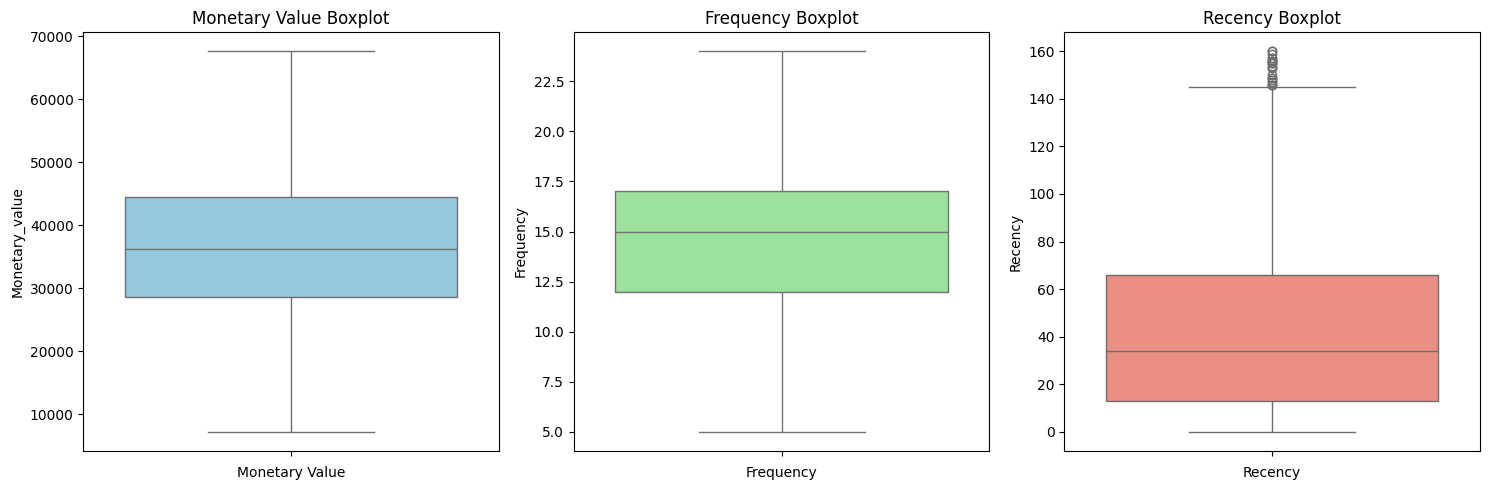

In [434]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['Monetary_value'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [435]:
# handling outlier data
mf_overlap_values = monetary_outliers_df.index.intersection(frequency_outliers_df.index)
fr_overlap_values = frequency_outliers_df.index.intersection(recency_outliers_df.index)
mr_overlap_values = monetary_outliers_df.index.intersection(recency_outliers_df.index)


In [436]:
mf_overlap_values

Index([363, 669, 771, 824], dtype='int64')

In [437]:
fr_overlap_values

Index([], dtype='int64')

In [438]:
mr_overlap_values

Index([], dtype='int64')

In [439]:
monetary_only_outliers = monetary_outliers_df.drop(mf_overlap_values)
frequency_only_outliers = frequency_outliers_df.drop(mf_overlap_values)
monetary_and_frequency_outliers = monetary_outliers_df.loc[mf_overlap_values]

***WEATHER***

In [440]:
weather_df.head(10)

,City,Date,Temperature,Weather_Description
0,Chicago,2022-08-05,11.32,rain
1,Chicago,2021-12-12,11.32,snow
2,Chicago,2021-11-09,11.32,clear sky
3,Chicago,2021-05-16,11.32,thunderstorm
4,Chicago,2021-10-24,11.32,overcast clouds
5,Chicago,2022-05-24,11.32,broken clouds
6,Chicago,2022-03-13,11.32,broken clouds
7,Chicago,2021-01-13,11.32,broken clouds
8,Chicago,2021-11-04,11.32,thunderstorm
9,Chicago,2021-08-22,11.32,broken clouds


In [441]:
weather_df['Weather_Description'].unique()

array(['rain', 'snow', 'clear sky', 'thunderstorm', 'overcast clouds',
       'broken clouds', 'drizzle', 'fog'], dtype=object)

In [442]:
#categorize weather as good or bad

def categorize_weather(description):
    if 'rain' in description or 'snow' in description or 'thunderstorm' in description or 'drizzle' in description or 'fog' in description :
        return 'Bad'
    return 'Good'

weather_df['Weather_Condition'] = weather_df['Weather_Description'].apply(categorize_weather)


In [443]:
# Aggregate weather data to ensure one record per date
weather_df_agg = weather_df.groupby('Date')['Weather_Condition'].first().reset_index()


In [444]:
# Merge weather data into sales_df
sales_df = sales_df.merge(
    weather_df_agg,
    how='left',
    left_on='invoice_date',
    right_on='Date'
)

# Drop the redundant 'Date' column after the merge
sales_df.drop(columns=['Date'], inplace=True)

sales_df.head(10)


,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales,Weather_Condition
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60,Good
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84,Good
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78,Good
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92,Good
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50,Good
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007,1575.15,Good
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033,4268.08,Good
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026,5594.40,Bad
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026,4170.39,Good
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019,8488.44,Good


***Holidays***

In [445]:
holidays_df.head(10)

,Date,Name,Type
0,2022-01-01,New Year's Day,Local holiday
5,2022-01-01,New Year's Day,National holiday
6,2022-01-03,New Year's Day (substitute),Local holiday
8,2022-01-04,World Braille Day,United Nations observance
9,2022-01-06,Epiphany,Christian
10,2022-01-07,Orthodox Christmas Day,Orthodox
11,2022-01-07,International Programmers' Day,Worldwide observance
12,2022-01-07,Estelle Reel Day,Local observance
13,2022-01-08,Battle of New Orleans,Local observance
14,2022-01-13,Stephen Foster Memorial Day,Observance


In [446]:
#check if a sale is made on a holiday
sales_df['is_holiday'] = sales_df['invoice_date'].isin(holidays_df['Date']).astype(int)

In [447]:
sales_df.head(10)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales,Weather_Condition,is_holiday
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60,Good,1
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84,Good,1
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78,Good,1
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92,Good,0
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50,Good,1
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007,1575.15,Good,0
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033,4268.08,Good,1
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026,5594.40,Bad,1
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026,4170.39,Good,1
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019,8488.44,Good,1


***Stores***

In [448]:
stores_df.head(10)

,Store_ID,shopping_mall,Location,Size,Category
0,S0020,Istinye Park,Dallas,Small,Furniture
1,S0021,Metrocity,Chicago,Large,Clothing
2,S0040,Mall of Istanbul,San Francisco,Small,Furniture
3,S0004,Viaport Outlet,Chicago,Medium,Books
4,S0025,Mall of Istanbul,Chicago,Small,Books
5,S0007,Metropol AVM,San Francisco,Large,Books
6,S0033,Mall of Istanbul,Dallas,Large,Electronics
7,S0026,Mall of Istanbul,Dallas,Large,Books
8,S0017,Viaport Outlet,Chicago,Medium,Books
9,S0008,Mall of Istanbul,Chicago,Small,Electronics


In [449]:
#total store sales
store_sales = sales_df.groupby('Store_ID')['total_sales'].sum().reset_index(name='total_store_sale')

In [450]:
#store performance
# Define performance thresholds
# Calculate quantiles for performance categories
low_threshold = store_sales['total_store_sale'].quantile(0.25)
medium_threshold = store_sales['total_store_sale'].quantile(0.75)

# Define a function that categorizes performance based on quantiles
def categorize_performance(sales):
    if sales >= medium_threshold:
        return 'High'
    elif sales >= low_threshold:
        return 'Medium'
    else:
        return 'Low'

# Apply categorization
store_sales['performance'] = store_sales['total_store_sale'].apply(categorize_performance)


In [451]:
stores_df= stores_df.merge(store_sales, on='Store_ID', how='left')

In [452]:
#salespersquarefoot

# Temporary mapping for size categories to numerical values in square feet
size_mapping = {
    'Small': 1000,
    'Medium': 5000,
    'Large': 10000
}

# Use the temporary mapping for the size calculation
stores_df['Sales_Per_Sqft'] = (
    stores_df['total_store_sale'] / stores_df['Size'].map(size_mapping)
).round(4)


In [453]:
stores_df.head(10)

,Store_ID,shopping_mall,Location,Size,Category,total_store_sale,performance,Sales_Per_Sqft
0,S0020,Istinye Park,Dallas,Small,Furniture,670852.33,Low,670.85
1,S0021,Metrocity,Chicago,Large,Clothing,766527.72,Medium,76.65
2,S0040,Mall of Istanbul,San Francisco,Small,Furniture,761768.95,Medium,761.77
3,S0004,Viaport Outlet,Chicago,Medium,Books,803863.66,High,160.77
4,S0025,Mall of Istanbul,Chicago,Small,Books,748390.63,Medium,748.39
5,S0007,Metropol AVM,San Francisco,Large,Books,748743.62,Medium,74.87
6,S0033,Mall of Istanbul,Dallas,Large,Electronics,709106.71,Medium,70.91
7,S0026,Mall of Istanbul,Dallas,Large,Books,678098.74,Low,67.81
8,S0017,Viaport Outlet,Chicago,Medium,Books,804624.71,High,160.92
9,S0008,Mall of Istanbul,Chicago,Small,Electronics,738583.33,Medium,738.58


In [454]:
#latitude and logitude

# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="store_locator")

# Function to fetch latitude and longitude using Geopy
def get_lat_lon_geopy(location):
    try:
        location_data = geolocator.geocode(location, timeout=10)  # Add a timeout to handle long requests
        if location_data:
            return location_data.latitude, location_data.longitude
        else:
            print(f"Failed to fetch data for {location}.")
            return None, None
    except GeocoderTimedOut:
        print(f"Timed out while fetching data for {location}.")
        return None, None

# Fetch and append latitude and longitude for each location in stores_df
stores_df['latitude'] = None
stores_df['longitude'] = None

for location in store_locations:
    lat, lon = get_lat_lon_geopy(location)
    # Update the DataFrame in-place for the current location
    stores_df.loc[stores_df['Location'] == location, ['latitude', 'longitude']] = lat, lon



In [455]:
stores_df.head(10)

,Store_ID,shopping_mall,Location,Size,Category,total_store_sale,performance,Sales_Per_Sqft,latitude,longitude
0,S0020,Istinye Park,Dallas,Small,Furniture,670852.33,Low,670.85,32.78,-96.80
1,S0021,Metrocity,Chicago,Large,Clothing,766527.72,Medium,76.65,41.88,-87.62
2,S0040,Mall of Istanbul,San Francisco,Small,Furniture,761768.95,Medium,761.77,37.78,-122.42
3,S0004,Viaport Outlet,Chicago,Medium,Books,803863.66,High,160.77,41.88,-87.62
4,S0025,Mall of Istanbul,Chicago,Small,Books,748390.63,Medium,748.39,41.88,-87.62
5,S0007,Metropol AVM,San Francisco,Large,Books,748743.62,Medium,74.87,37.78,-122.42
6,S0033,Mall of Istanbul,Dallas,Large,Electronics,709106.71,Medium,70.91,32.78,-96.80
7,S0026,Mall of Istanbul,Dallas,Large,Books,678098.74,Low,67.81,32.78,-96.80
8,S0017,Viaport Outlet,Chicago,Medium,Books,804624.71,High,160.92,41.88,-87.62
9,S0008,Mall of Istanbul,Chicago,Small,Electronics,738583.33,Medium,738.58,41.88,-87.62


In [456]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14601 entries, 0 to 14600
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   invoice_no         14601 non-null  object        
 1   customer_id        14601 non-null  object        
 2   category           14601 non-null  object        
 3   quantity           14601 non-null  int64         
 4   price              14601 non-null  float64       
 5   invoice_date       14601 non-null  datetime64[ns]
 6   shopping_mall      14601 non-null  object        
 7   Store_ID           14601 non-null  object        
 8   total_sales        14601 non-null  float64       
 9   Weather_Condition  14601 non-null  object        
 10  is_holiday         14601 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [457]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Store_ID          50 non-null     object 
 1   shopping_mall     50 non-null     object 
 2   Location          50 non-null     object 
 3   Size              50 non-null     object 
 4   Category          50 non-null     object 
 5   total_store_sale  50 non-null     float64
 6   performance       50 non-null     object 
 7   Sales_Per_Sqft    50 non-null     float64
 8   latitude          50 non-null     object 
 9   longitude         50 non-null     object 
dtypes: float64(2), object(8)
memory usage: 4.0+ KB


In [458]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 3985 non-null   object        
 1   Date                 3985 non-null   datetime64[ns]
 2   Temperature          3985 non-null   float64       
 3   Weather_Description  3985 non-null   object        
 4   Weather_Condition    3985 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 155.8+ KB


In [459]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1694 entries, 0 to 1906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1694 non-null   datetime64[ns]
 1   Name    1694 non-null   object        
 2   Type    1694 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 52.9+ KB


In [460]:
# Check for duplicates in each dataset

duplicates_summary = {
    "Customers": customers_df.duplicated().sum(),
    "Sales": sales_df.duplicated().sum(),
    "Stores": stores_df.duplicated().sum(),
    "Weather": weather_df.duplicated().sum(),
    "Holidays": holidays_df.duplicated().sum()
}

duplicates_summary

{'Customers': 0, 'Sales': 0, 'Stores': 0, 'Weather': 0, 'Holidays': 0}

In [461]:
#converting them to csv for reporting
sales_df.to_csv('final_sales_data.csv', index=False)
stores_df.to_csv('final_stores_data.csv', index=False)

# **EXPLORATORY DATA ANALYSIS**

---



**Monthly Sales trends**

In [462]:
sales_df.head(10)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales,Weather_Condition,is_holiday
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60,Good,1
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84,Good,1
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78,Good,1
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92,Good,0
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50,Good,1
5,I000007,C000701,Clothing,3,525.05,2022-07-26,Viaport Outlet,S0007,1575.15,Good,0
6,I000008,C000021,Shoes,8,533.51,2021-09-23,Forum Istanbul,S0033,4268.08,Good,1
7,I000009,C000615,Clothing,7,799.20,2021-04-12,Kanyon,S0026,5594.40,Bad,1
8,I000012,C000215,Home,7,595.77,2022-12-10,Viaport Outlet,S0026,4170.39,Good,1
9,I000015,C000088,Books,9,943.16,2021-08-10,Viaport Outlet,S0019,8488.44,Good,1


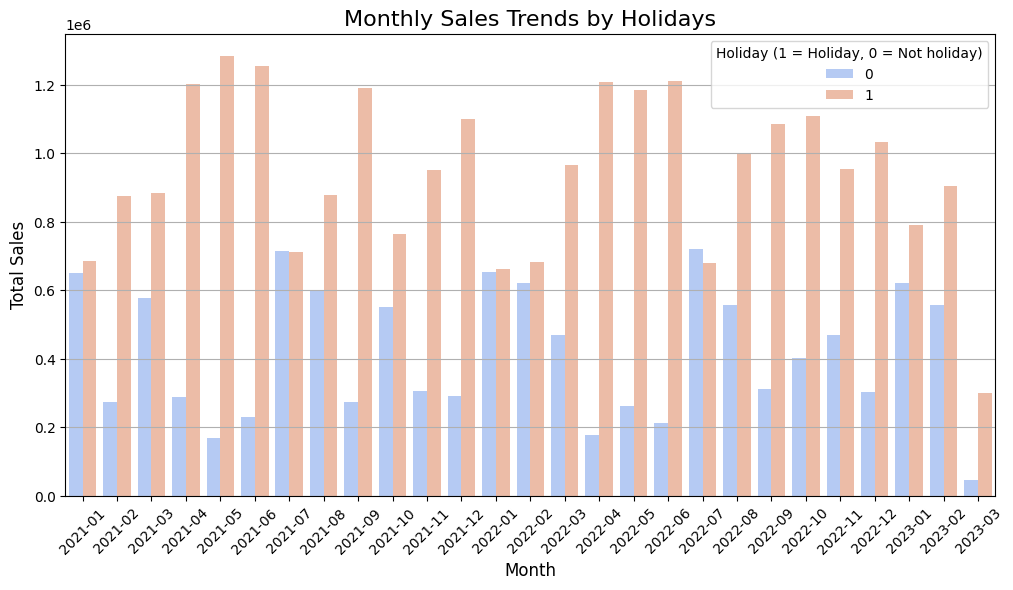

In [463]:
#monthly holiday sales
# Convert invoice_date to datetime format if not already
sales_df['invoice_date'] = pd.to_datetime(sales_df['invoice_date'])

# Aggregate sales data by month and holidays without modifying the original dataframe
holiday_trends = sales_df.copy()
holiday_trends['month'] = holiday_trends['invoice_date'].dt.to_period('M')  # Temporarily create the 'month' column
holiday_trends = holiday_trends.groupby(['month', 'is_holiday'])['total_sales'].sum().reset_index()

# Convert 'month' to string for proper plotting
holiday_trends['month'] = holiday_trends['month'].astype(str)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=holiday_trends,
    x='month',
    y='total_sales',
    hue='is_holiday',  # Separate bars for holidays and non-holidays
    palette='coolwarm'
)
plt.title('Monthly Sales Trends by Holidays', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Holiday (1 = Holiday, 0 = Not holiday)', loc='upper right')
plt.grid(axis='y')
plt.show()




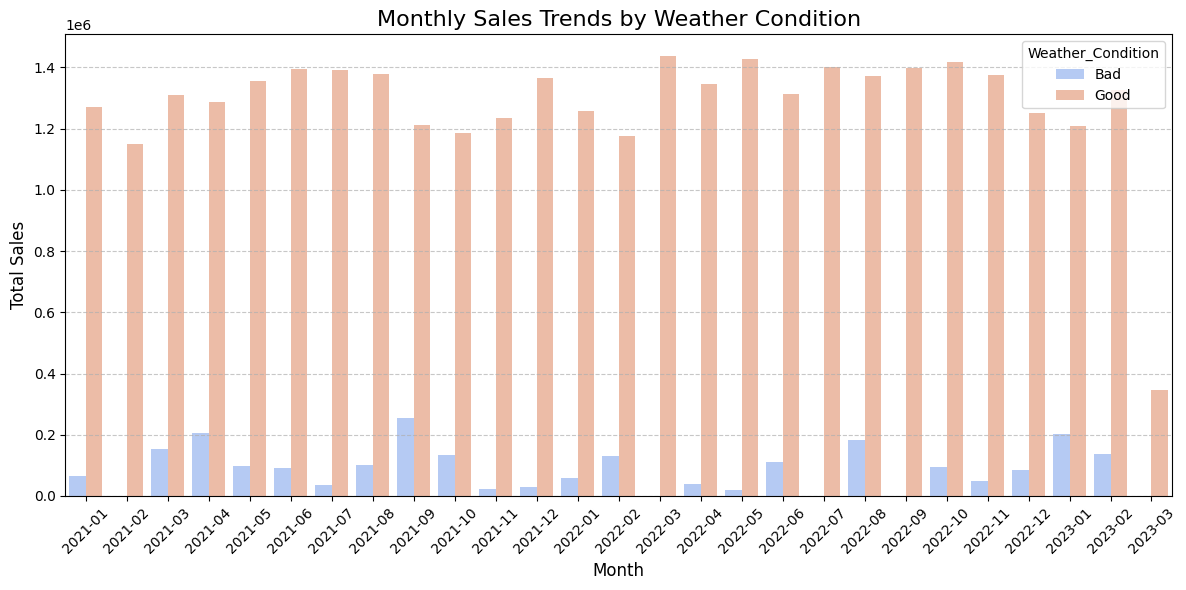

In [464]:
#monthly sales trends by weather

# Prepare the data for plotting
weather_trends = sales_df.copy()
weather_trends['month'] = weather_trends['invoice_date'].dt.to_period('M')  # Group by month
weather_trends = weather_trends.groupby(['month', 'Weather_Condition'])['total_sales'].sum().reset_index()

# Convert 'month' to string for proper plotting
weather_trends['month'] = weather_trends['month'].astype(str)


# Grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=weather_trends, x='month', y='total_sales', hue='Weather_Condition', palette='coolwarm')

# Add titles and labels
plt.title('Monthly Sales Trends by Weather Condition', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()





Identify drivers using Regression Analysis

In [465]:
sales_df.head(5)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales,Weather_Condition,is_holiday
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60,Good,1
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84,Good,1
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78,Good,1
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92,Good,0
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50,Good,1


In [466]:
#One-hot encode Weather_Condition
sales_df = pd.get_dummies(sales_df, columns=['Weather_Condition'], drop_first=False)

In [467]:
sales_df.head(5)

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,Store_ID,total_sales,is_holiday,Weather_Condition_Bad,Weather_Condition_Good
0,I000001,C000103,Shoes,5,747.12,2022-09-11,Mall of Istanbul,S0020,3735.60,1,False,True
1,I000002,C000436,Books,1,424.84,2022-09-11,Viaport Outlet,S0021,424.84,1,False,True
2,I000003,C000861,Clothing,6,491.13,2022-09-18,Forum Istanbul,S0040,2946.78,1,False,True
3,I000004,C000271,Electronics,4,804.48,2022-03-11,Mall of Istanbul,S0004,3217.92,0,False,True
4,I000005,C000107,Shoes,6,303.25,2023-03-07,Istinye Park,S0025,1819.50,1,False,True


In [468]:
#linear regression
# Ensure required columns are present
predictors = ['is_holiday', 'Weather_Condition_Good','Weather_Condition_Bad']

# Define predictors and target
X = sales_df[predictors]
y = sales_df['total_sales']

# Handle missing values
X = X.dropna()
y = y.loc[X.index]


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Fit regression model with weights
model = LinearRegression()
model.fit(X_train, y_train)

# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

coefficients

,Feature,Coefficient
0,is_holiday,19.42
1,Weather_Condition_Good,25.16
2,Weather_Condition_Bad,-25.16


**Insights**

Holidays (Coefficient = 19.42):

Holidays positively impact sales, increasing total sales by approximately 19.42 units compared to non-holidays suggesting holidays drive customer traffic and purchasing behavior

Weather_Condition_Good (Coefficient = 25.16):

Good weather has a strong positive effect on sales, increasing total sales by 25.16 units compared to neutral weather suggesting customers are more likely to visit physical stores or spend more when the weather is favorable

Weather_Condition_Bad (Coefficient = -25.16):

Bad weather has a strong negative impact on sales, decreasing total sales by 25.16 units compared to average or neutral weather suggesting adverse weather conditions likely discourage customers from shopping, particularly in physical stores

**Recommendations**

Leverage Holidays
* Offer holiday-exclusive discounts, bundles, and loyalty rewards to capitalize on increased traffic
* Stock up on high-demand products before holidays to meet increased customer demand
* Increase advertising campaigns around holidays, highlighting special deals and seasonal products

Maximize Sales in Good Weather

* Organize outdoor events (e.g., sidewalk sales) to take advantage of higher foot traffic
* Focus on weather-related products (e.g., summer items, beverages) during favorable conditions

Mitigate Sales Decline in Bad Weather

* Promote online shopping and home delivery options during bad weather
* Highlight features like curbside pickup or same-day delivery for customers hesitant to visit stores


**Product and Store performances**

Products

In [469]:
# Calculate total sales by product
product_sales = sales_df.groupby('category')['total_sales'].sum().reset_index(name='total_product_sales')
product_sales = product_sales.sort_values(by='total_product_sales', ascending=False)

product_sales


,category,total_product_sales
1,Clothing,7547404.42
3,Home,7470232.79
4,Shoes,7333173.91
2,Electronics,7307923.88
0,Books,7225196.33


In [470]:
product_frequency = sales_df.groupby('category').size().reset_index(name='transaction_count')

product_frequency

,category,transaction_count
0,Books,2889
1,Clothing,2988
2,Electronics,2874
3,Home,2961
4,Shoes,2889


In [471]:
# Merge the data into a single DataFrame
product_analysis = pd.merge(product_sales, product_frequency, on='category')

# Sort by total_sales to identify most and least popular categories
product_analysis = product_analysis.sort_values(by='total_product_sales', ascending=False)

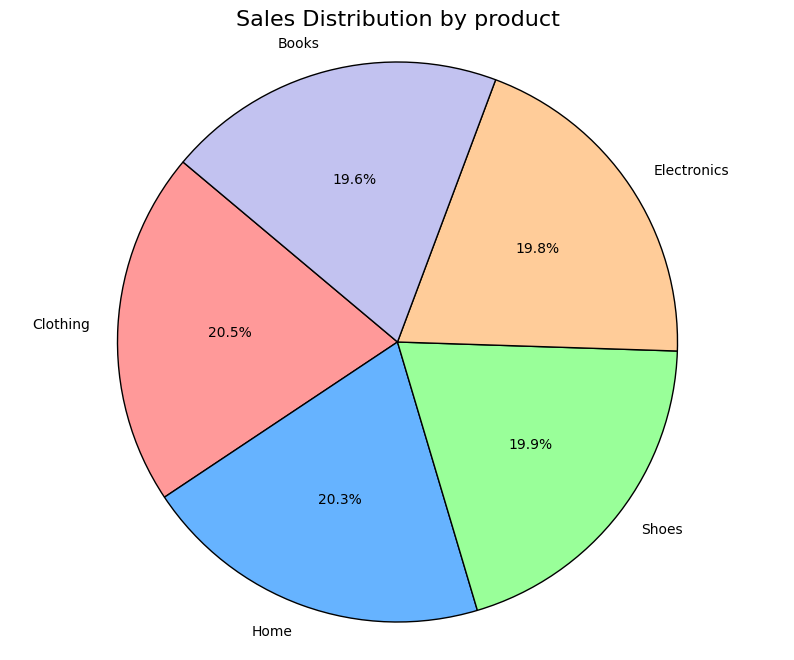

In [472]:
#plot a pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']  # Define unique colors for each category
plt.pie(
    product_analysis['total_product_sales'],
    labels=product_analysis['category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Sales Distribution by product', fontsize=16)
plt.axis('equal')  # Ensures the pie chart is a circle
plt.show()

Stores

In [473]:
stores_df.head(5)

,Store_ID,shopping_mall,Location,Size,Category,total_store_sale,performance,Sales_Per_Sqft,latitude,longitude
0,S0020,Istinye Park,Dallas,Small,Furniture,670852.33,Low,670.85,32.78,-96.80
1,S0021,Metrocity,Chicago,Large,Clothing,766527.72,Medium,76.65,41.88,-87.62
2,S0040,Mall of Istanbul,San Francisco,Small,Furniture,761768.95,Medium,761.77,37.78,-122.42
3,S0004,Viaport Outlet,Chicago,Medium,Books,803863.66,High,160.77,41.88,-87.62
4,S0025,Mall of Istanbul,Chicago,Small,Books,748390.63,Medium,748.39,41.88,-87.62


In [474]:
# Prepare data for HeatMap
store_heatmap_data = stores_df[['latitude', 'longitude', 'total_store_sale']].values.tolist()

# Create a HeatMap
store_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)  # Central USA coordinates
HeatMap(store_heatmap_data, radius=15).add_to(store_map)

store_map


Chicago seems to be high revenue generating location

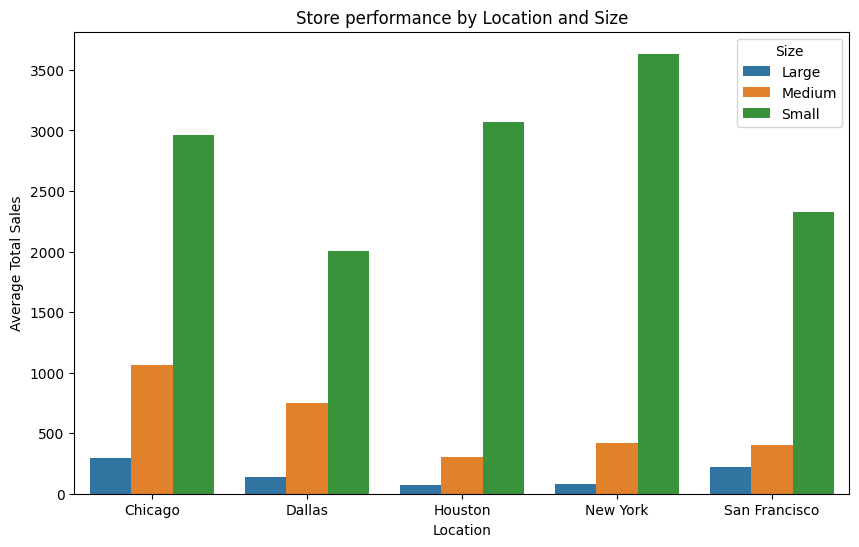

In [475]:
# Compare features of stores
store_analysis = stores_df.groupby(['Location', 'Size'])['Sales_Per_Sqft'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=store_analysis, x='Location', y='Sales_Per_Sqft', hue='Size')
plt.title('Store performance by Location and Size')
plt.ylabel('Average Total Sales')
plt.show()


**Insights**

Size-wise observations:

*   Small Stores Outperform Larger Stores
*   Medium-sized stores strike a better balance between operational costs and revenue generation


Location-Wise observations:

*  New York and Houston : Small stores significantly outperform medium and large stores
*   Chicago, Dallas, and San Francisco :
Small stores maintain dominance, with medium stores following closely, and large stores lagging


**Recommendations**

Small Stores :

*  Consider replicating the small store model in high-demand areas
*  Focus on stocking high-demand products and ensuring efficient inventory turnover

Medium Stores :
*   Medium stores are performing well but could further improve sales density by optimizing layout and inventory

Large Stores:

* Consider downsizing or converting portions of the space into other revenue-generating areas (e.g., rental spaces, storage hubs)
* Boost foot traffic through localized marketing campaigns or promotions targeting customers in the vicinity

Locations:


*  New York and Houston: Focus on leveraging the success of small stores by expanding their presence
* Chicago, Dallas, and San Francisco:
Investigate reasons behind lower sales in medium and large stores (e.g., customer preferences, local competition).


**Customer Segmentation**

In [476]:
#scale data
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["Monetary_value", "Frequency", "Recency"]])


In [477]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)

non_outliers_df = non_outliers_df.copy() #Prevents unintended side effects or memory-related issues when modifying the DataFrame.
non_outliers_df['Cluster'] = kmeans.fit_predict(scaled_data)


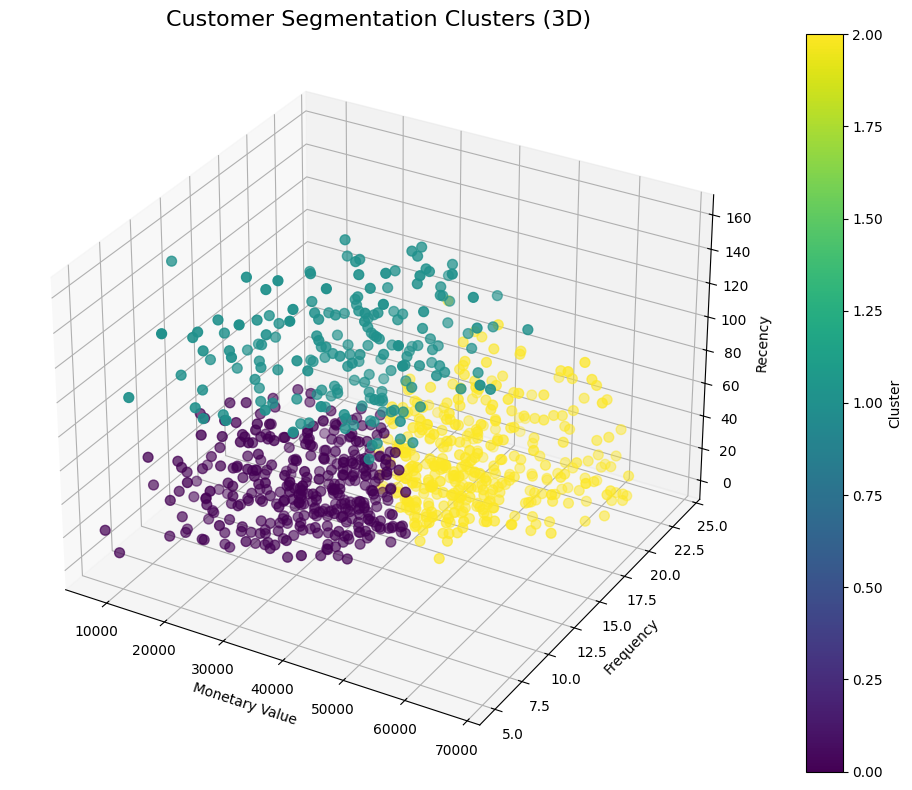

In [478]:
# 3D scatter plot for clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    non_outliers_df['Monetary_value'],
    non_outliers_df['Frequency'],
    non_outliers_df['Recency'],
    c=non_outliers_df['Cluster'],
    cmap='viridis',
    s=50
)

# Add plot details
ax.set_title("Customer Segmentation Clusters (3D)", fontsize=16)
ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
fig.colorbar(scatter, ax=ax, label="Cluster")

plt.tight_layout()
plt.show()


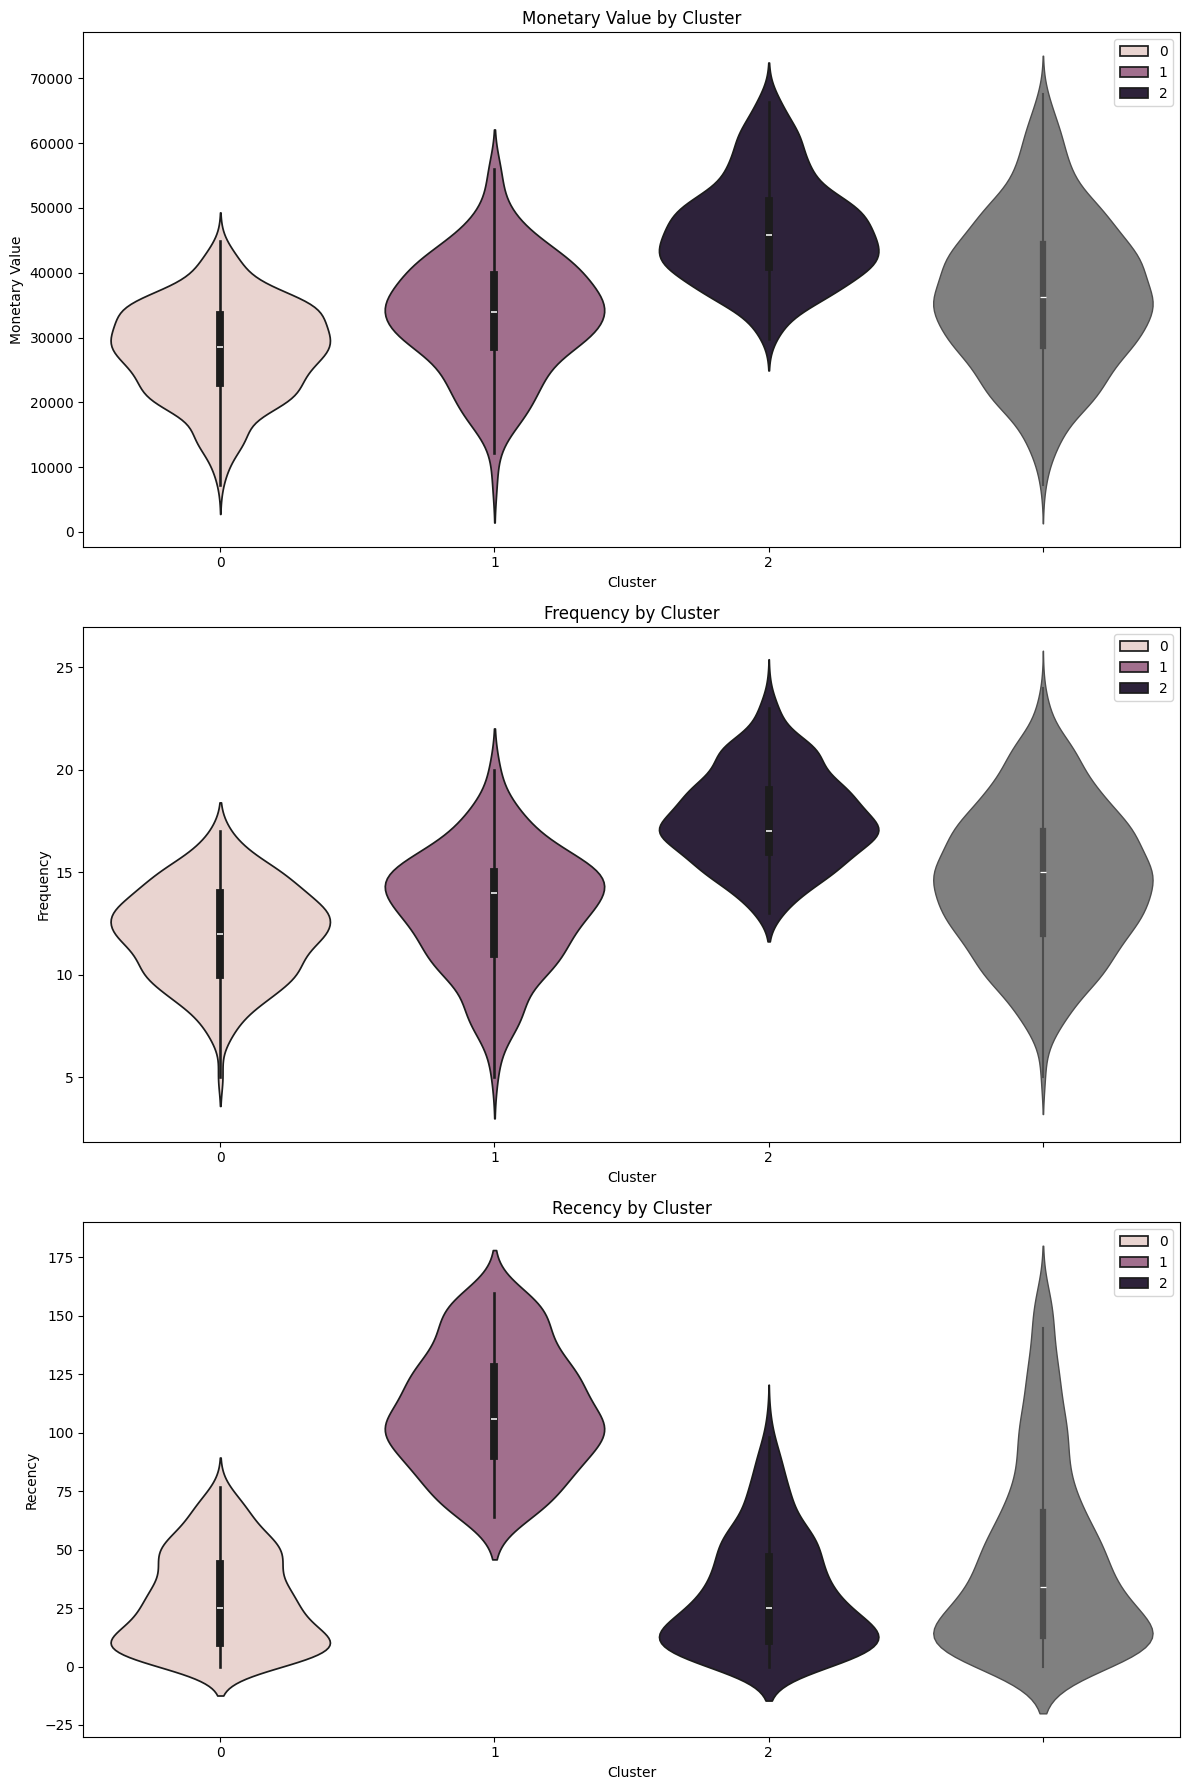

In [479]:
#violin plots for non outlier data

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Monetary_value'], hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Monetary_value'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

**Cluster 0: Re engage**

Low Recency, Low Frequency, and Low Monetary Value

Actions:
Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again

**Cluster 1: At risk**

High Recency, Moderate Frequency, and Moderate Monetary Value

Actions:
Send personalized messages with exclusive offers, Highlight new arrivals or promotions to encourage them to return.

**Cluster 2: Retain**

Low Recency, High Frequency, and High Monetary Value

Provide VIP perks, such as early access to sales, special discounts, or free shipping by introducing a loyalty program with rewards for continued purchases



In [480]:
outlier_clusters_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency,Cluster
113,C000114,70948.27,20,2023-02-10,26,4
136,C000137,73095.83,24,2023-02-21,15,4
160,C000161,83470.57,21,2023-03-01,7,4
293,C000294,75591.04,20,2022-10-13,146,4
380,C000381,78668.61,22,2023-02-28,8,4
406,C000407,70529.70,20,2023-03-01,7,4
675,C000676,78478.48,22,2023-02-16,20,4
882,C000883,71124.85,20,2022-12-18,80,4
11,C000012,54683.18,25,2023-03-01,7,5
348,C000349,58379.17,28,2023-01-13,54,5


In [481]:
#manual clusters for outlieer data
monetary_only_outliers["Cluster"] = 4
frequency_only_outliers["Cluster"] = 5
monetary_and_frequency_outliers["Cluster"] = 6

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency,Cluster
113,C000114,70948.27,20,2023-02-10,26,4
136,C000137,73095.83,24,2023-02-21,15,4
160,C000161,83470.57,21,2023-03-01,7,4
293,C000294,75591.04,20,2022-10-13,146,4
380,C000381,78668.61,22,2023-02-28,8,4
406,C000407,70529.70,20,2023-03-01,7,4
675,C000676,78478.48,22,2023-02-16,20,4
882,C000883,71124.85,20,2022-12-18,80,4
11,C000012,54683.18,25,2023-03-01,7,5
348,C000349,58379.17,28,2023-01-13,54,5


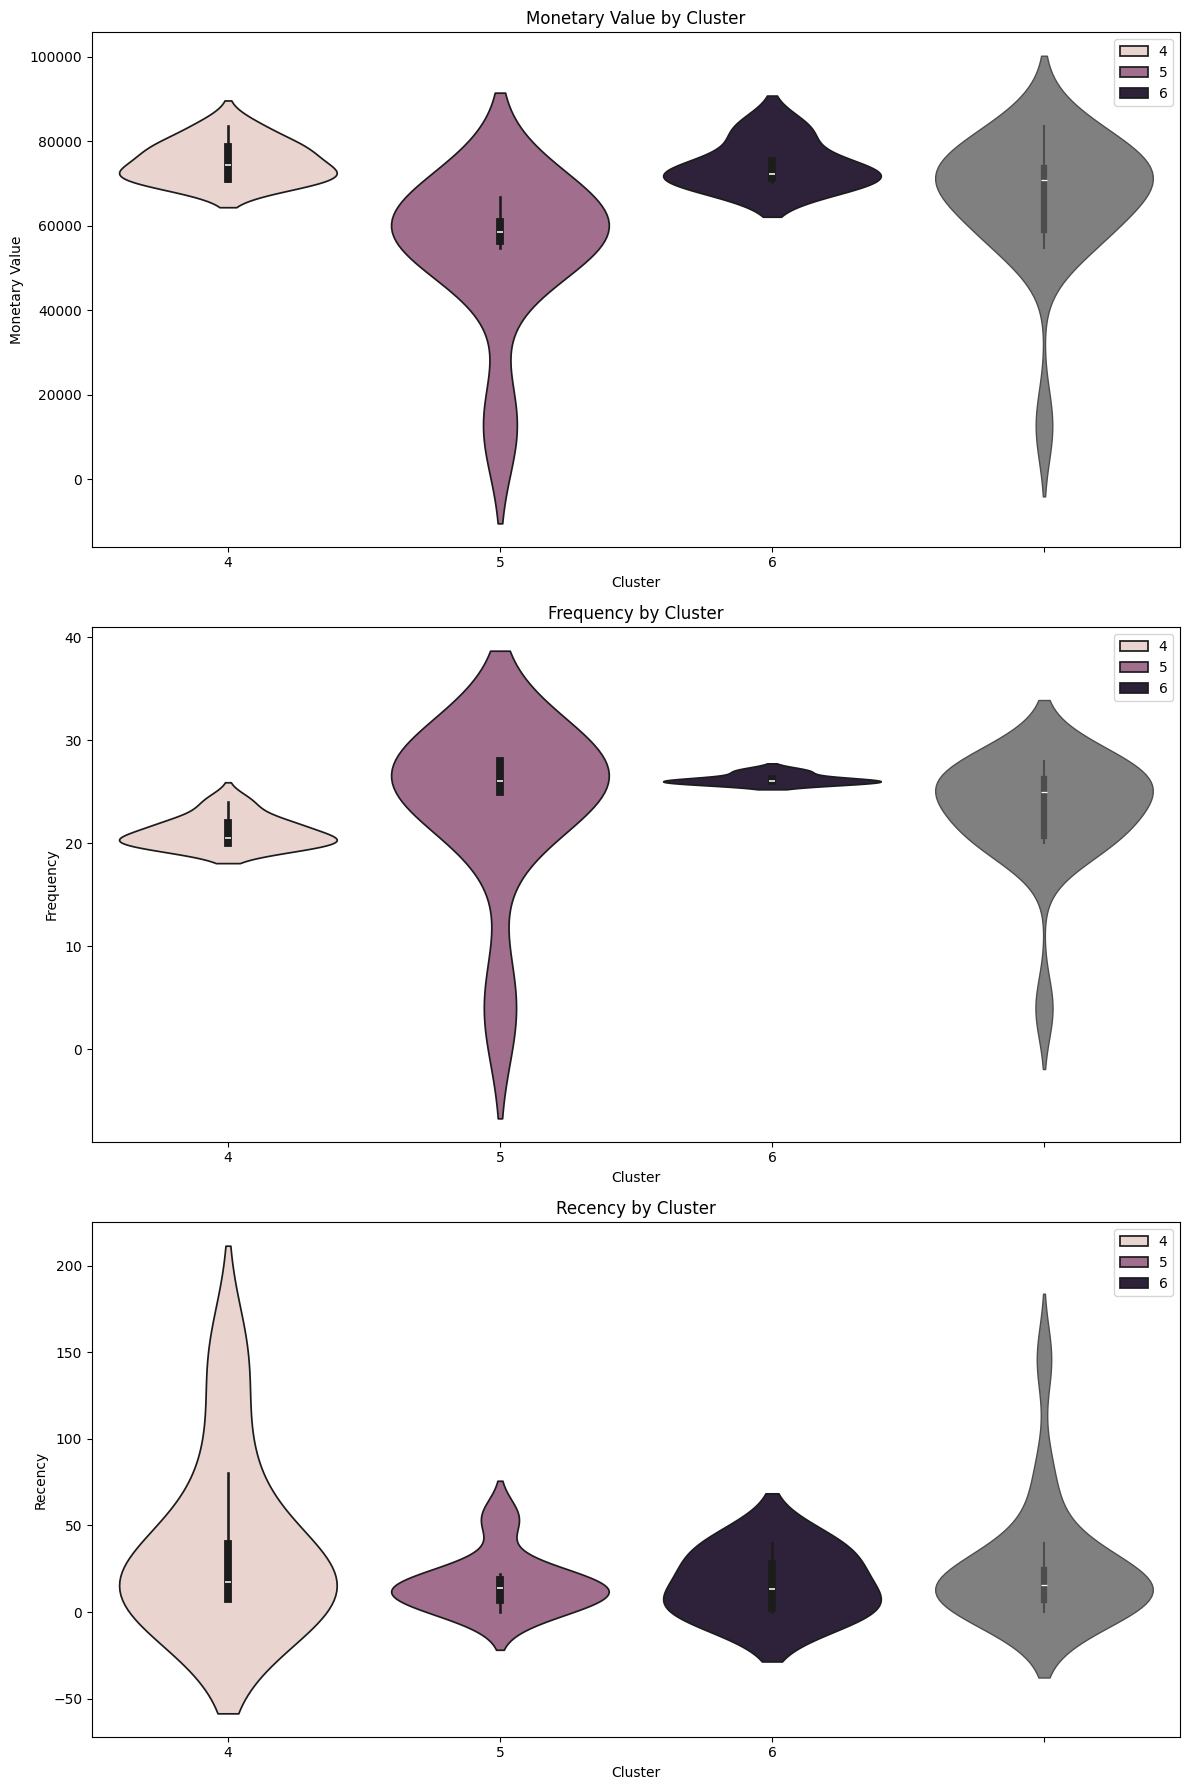

In [482]:
#violin plots for outlier data

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Monetary_value'], hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Monetary_value'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

**Cluster 4 (Monetary outliers): Pamper**

High Recency, Moderate Frequency, Moderate Monetary Value

Actions:
Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again

**Cluster 5 (Frequency outliers): Upsell**

Low Recency, High Frequency, and Low Monetary Value

Actions:
Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement

**Cluster 6 (Monetary and frequency outliers): Reward**

Low Recency, High Frequency, and High Monetary Value

Actions:
Provide VIP perks, such as early access to sales, special discounts, or free shipping by introducing a loyalty program with rewards for continued purchases

In [483]:
cluster_labels = {
    0: "RE-ENGAGE",
    1: "AT RISK",
    2: "RETAIN",
    4: "PAMPER",
    5: "UPSELL",
    6: "REWARD"
}

In [484]:
clustered_df = pd.concat([non_outliers_df, outlier_clusters_df])

clustered_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency,Cluster
0,C000001,43290.57,15,2023-02-05,31,2
1,C000002,27607.01,14,2022-12-04,94,1
2,C000003,35368.57,15,2022-12-22,76,1
3,C000004,35018.94,13,2023-02-20,16,0
4,C000005,28847.11,16,2023-02-11,25,0
...,...,...,...,...,...,...
983,C000984,66708.45,28,2023-02-20,16,5
363,C000364,73036.07,26,2023-03-05,3,6
669,C000670,82444.77,27,2023-02-12,24,6
771,C000772,71478.95,26,2023-01-27,40,6


In [485]:
clustered_df["ClusterLabel"] = clustered_df["Cluster"].map(cluster_labels)

clustered_df

,customer_id,Monetary_value,Frequency,lastinvoicedate,Recency,Cluster,ClusterLabel
0,C000001,43290.57,15,2023-02-05,31,2,RETAIN
1,C000002,27607.01,14,2022-12-04,94,1,AT RISK
2,C000003,35368.57,15,2022-12-22,76,1,AT RISK
3,C000004,35018.94,13,2023-02-20,16,0,RE-ENGAGE
4,C000005,28847.11,16,2023-02-11,25,0,RE-ENGAGE
...,...,...,...,...,...,...,...
983,C000984,66708.45,28,2023-02-20,16,5,UPSELL
363,C000364,73036.07,26,2023-03-05,3,6,REWARD
669,C000670,82444.77,27,2023-02-12,24,6,REWARD
771,C000772,71478.95,26,2023-01-27,40,6,REWARD


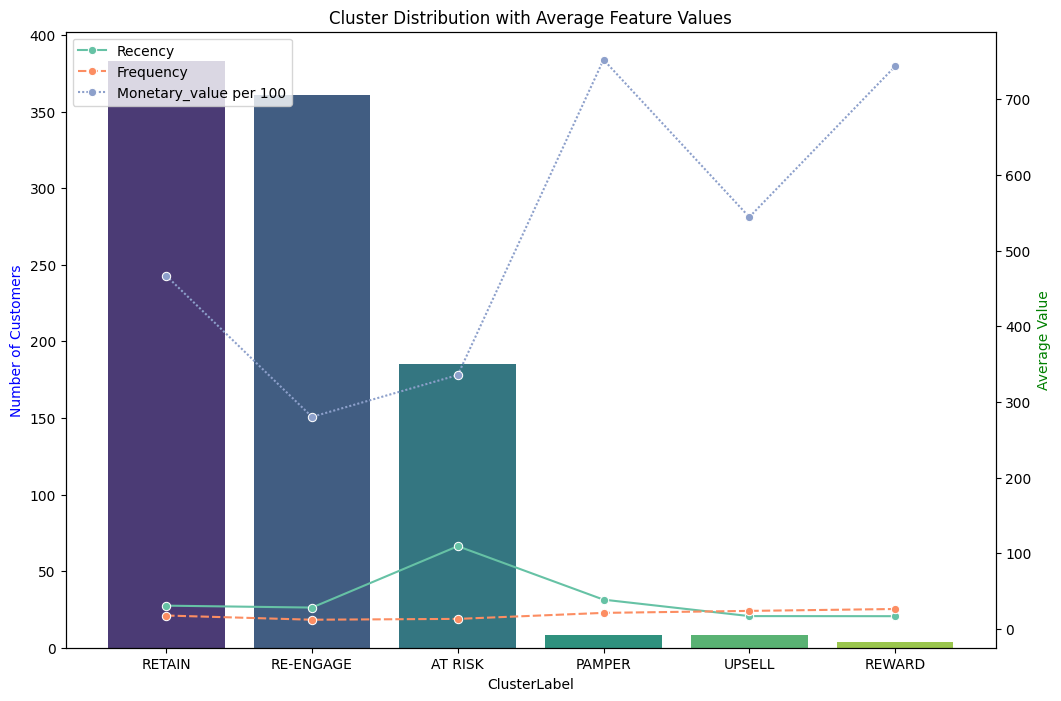

In [486]:
cluster_counts = clustered_df['ClusterLabel'].value_counts()
clustered_df["Monetary_value per 100"] = clustered_df["Monetary_value"]/100
feature_means = clustered_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'Monetary_value per 100']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

RETAIN:

Largest cluster with customers showing low recency, high frequency, and moderate-to-high monetary value.
These are your most loyal and engaged customers.
Action: Focus on retaining them with loyalty programs and personalized offers.

RE-ENGAGE:

Second largest cluster, with lower frequency and monetary value, indicating these customers are not yet fully engaged.
Action: Use targeted marketing campaigns with discounts or promotions to boost engagement and spending.

AT RISK:

Customers with high recency and moderate frequency and monetary value, indicating they were previously engaged but have reduced activity.
Action: Implement win-back campaigns with exclusive offers or reminders about products they’ve purchased before.

PAMPER, UPSELL, REWARD:

Smaller niche clusters:
PAMPER: Likely low-frequency but valuable customers—reward their purchases with personalized perks.
UPSELL: High spenders—focus on cross-sell and upsell opportunities.
REWARD: Customers with moderate spending—encourage loyalty through incentives.